In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import copy
%matplotlib inline

# 1. Define Helper Functions and Variables

In [2]:
#useful valuables
IMAGE_SIZE = (1280, 720)

#plotings
def multiplot(images, figure_size = (12,9), cmap=None):
    plt.figure(figsize=figure_size)
    n_images = len(images)
    nrow = np.ceil(n_images/2)
    for i in range(n_images):
        plt.subplot(nrow, 2, i+1)
        plt.tight_layout()
        if cmap:
            plt.imshow(images[i], cmap=cmap)
        else:
            plt.imshow(images[i])

In [3]:
# Define camera Calibration functions
def points(nx, ny, img_path, save_path=None):
    #prepare object points
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:ny, 0:nx].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all images
    objpoints = [] #3d points in real world space
    imgpoints = [] #2d points in image plane
    
    images = glob.glob(img_path)
    
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray, (ny,nx), None)
        
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (ny,nx), corners, ret)
            if save_path:
                write_name = 'corner_found'+str(idx)+'.jpg'
                cv2.imwrite(save_path+write_name, img)
        #objpoints = np.concatenate(objpoints)
        #imgpoints = np.concatenate(imgpoints)
    return objpoints, imgpoints

def cam_cal(img_size, objpoints, imgpoints, save_path = None):
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    if save_path:
        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump( dist_pickle, open(save_path, "wb"))
    
    return mtx, dist

def undist(img, mtx, dist, imshow = False, save_path = None):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    if imshow == True:
        f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(dst)
        ax2.set_title('undistorted Image', fontsize=30)
    
    if save_path:
        img = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_path, img)
    
    return dst

In [4]:
# Define thresholding functions
def sobel(img, kernel_size=3, thresh=(0,255), method='mag'):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if method == 'mag':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = kernel_size)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel_size)
        sobel = np.sqrt(sobelx**2+sobely**2)
    elif method == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = kernel_size)
        sobel = np.absolute(sobelx)
    elif method == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel_size)
        sobel = np.absolute(sobely)
    
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=thresh[0])&(scaled_sobel<=thresh[1])]=1
    
    return binary_output

# find the direction on the image thresh [0, pi/2]
def direction(img, kernel_size=3, thresh=(0.7, 1.3)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel_size)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0])&(grad_dir <= thresh[1])] = 1
    
    return binary_output

def RGB(image, space='R', thresh=(0,255)):
    if space=='R':
        mspace = image[:,:,0]
    elif space=='G':
        mspace = image[:,:,1]
    elif space=='B':
        mspace = image[:,:,2]
    binary = np.zeros_like(mspace)
    binary[(mspace > thresh[0]) & (mspace > thresh[0])] = 1
    return binary

def hls(image, space='H', thresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    if space == 'H':
        H = hls[:,:,0]
        binary = np.zeros_like(H)
        binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    elif space == 'L':
        L = hls[:,:,1]
        binary = np.zeros_like(L)
        binary[(L > thresh[0]) & (L <= thresh[1])] = 1
    elif space == 'S':
        S = hls[:,:,2]
        binary = np.zeros_like(S)
        binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def hsv(image, space='H', thresh=(0,255)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    if space == 'H':
        H = hsv[:,:,0]
        binary = np.zeros_like(H)
        binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    elif space == 'V':
        V = hsv[:,:,1]
        binary = np.zeros_like(V)
        binary[(V > thresh[0]) & (V <= thresh[1])] = 1
    elif space == 'S':
        S = hsv[:,:,2]
        binary = np.zeros_like(S)
        binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

# 2. Date Exploration
## Play around thresholds and functions

In [5]:
# grab objective points and image points
img_path = 'camera_cal/calibration*.jpg'
objpoints, imgpoints = points(6,9,img_path)

In [6]:
# calculate camera calibration coeffs
img = cv2.cvtColor(cv2.imread('test_images/test6.jpg'), cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])
mtx, dist = cam_cal(img_size, objpoints, imgpoints)

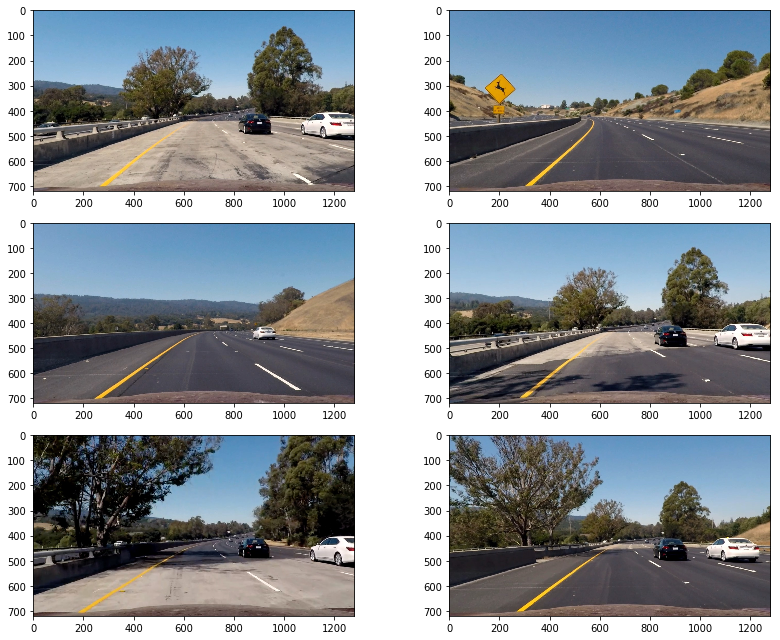

In [7]:
# undistort testing images
test_images_paths = glob.glob("test_images/test*.jpg")
test_images = []
for idx, fname in enumerate(test_images_paths):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_undist = undist(img, mtx, dist)
    test_images.append(img_undist)

multiplot(test_images)


## a. gradient direction thresholding - (0.5, 0.7)

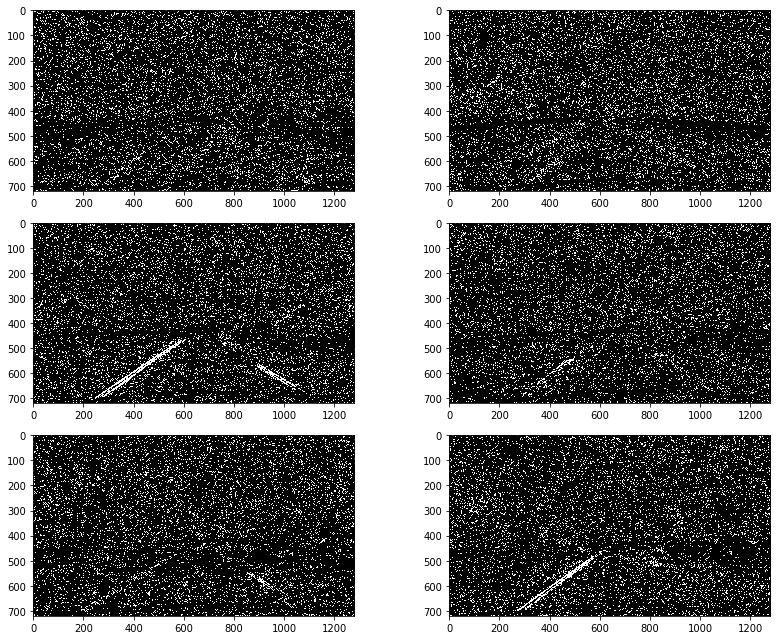

In [8]:
# direction thresholding
dir_binaries = []
for image in test_images:
    binary_dir = direction(image, kernel_size=9, thresh=(0.5, 0.7))
    dir_binaries.append(binary_dir)

multiplot(dir_binaries, cmap='gray')
    

## b. gradient x thresholding - (50, 255)

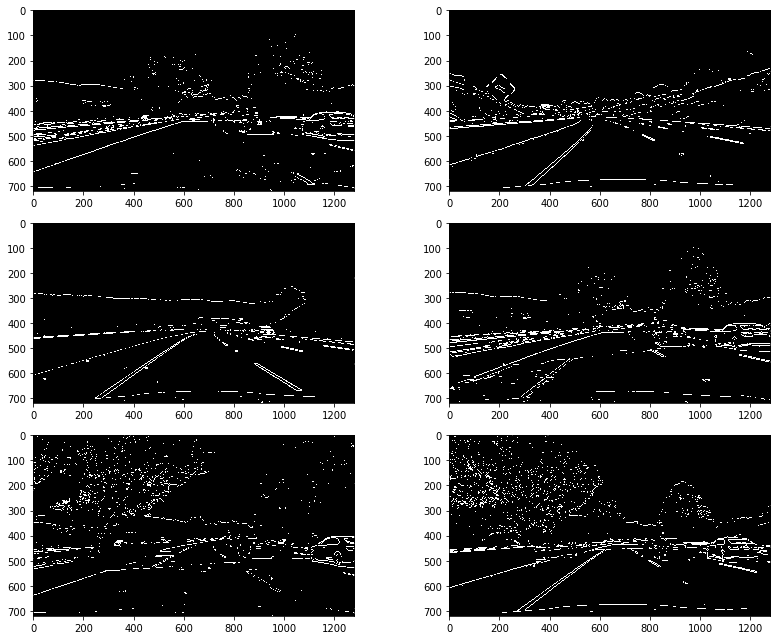

In [9]:
# gradiant over x orientation
gradx_binaries = []
for image in test_images:
    gradx = sobel(image, kernel_size=5, thresh=(50,255), method='x')
    gradx_binaries.append(gradx)

multiplot(gradx_binaries, cmap='gray')

## c. gradient y thresholding - (50, 150)

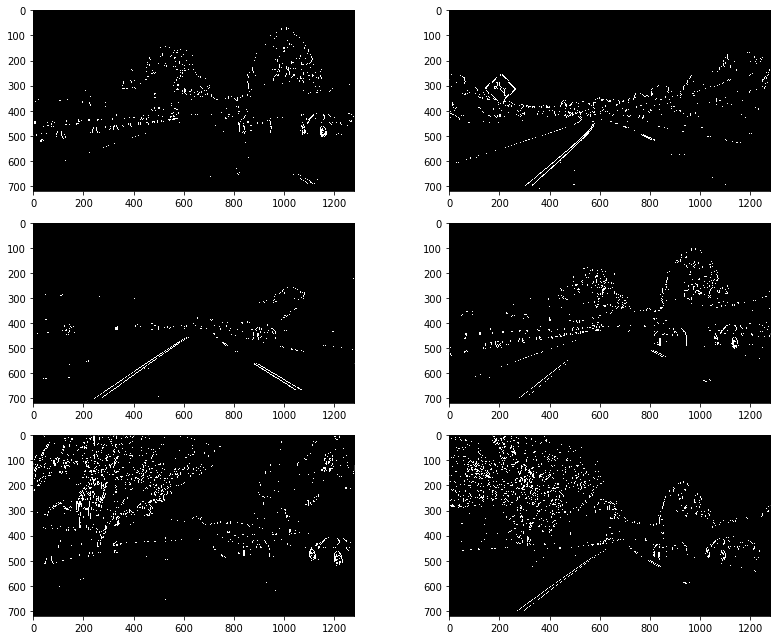

In [10]:
# gradiant over y orientation
grady_binaries = []
for image in test_images:
    grady = sobel(image, kernel_size=5, thresh=(50, 255), method='y')
    grady_binaries.append(grady)

multiplot(grady_binaries, cmap='gray')

## d. gradient magnitute thresholding - (50, 255)

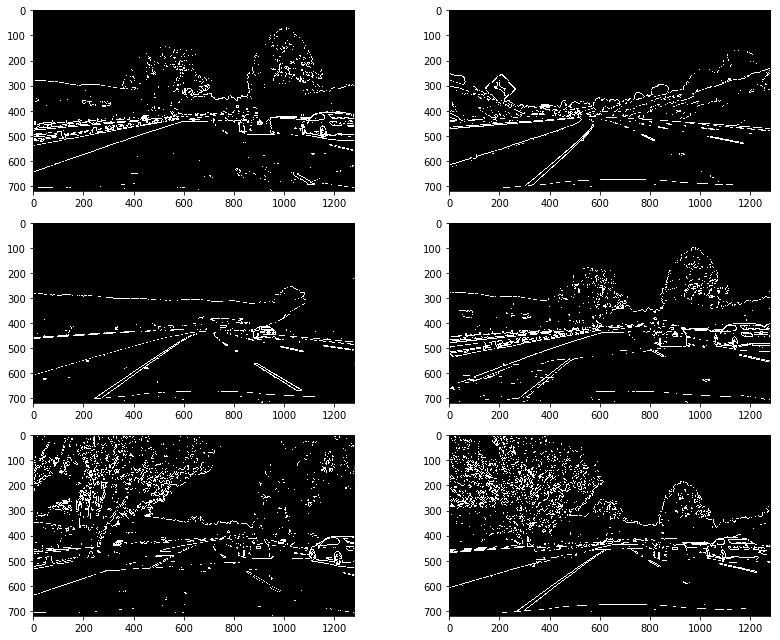

In [11]:
# magnitute gradiants
gradmag_binaries = []
for image in test_images:
    gradmag = sobel(image, kernel_size=5, thresh=(50,255), method='mag')
    gradmag_binaries.append(gradmag)

multiplot(gradmag_binaries, cmap='gray')

## e. RGB color space R thresholding - (220, 255)

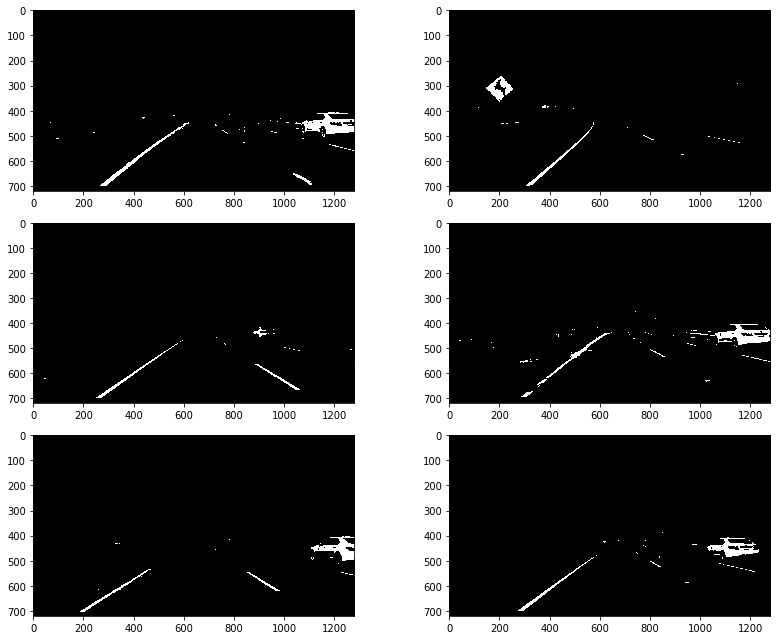

In [12]:
# RGB color space R thresholding
color_R_binaries = []
for image in test_images:
    R = RGB(image, space='R', thresh=(220,255))
    color_R_binaries.append(R)

multiplot(color_R_binaries, cmap='gray')

## f. RGB color space B thresholding - no valid threshold

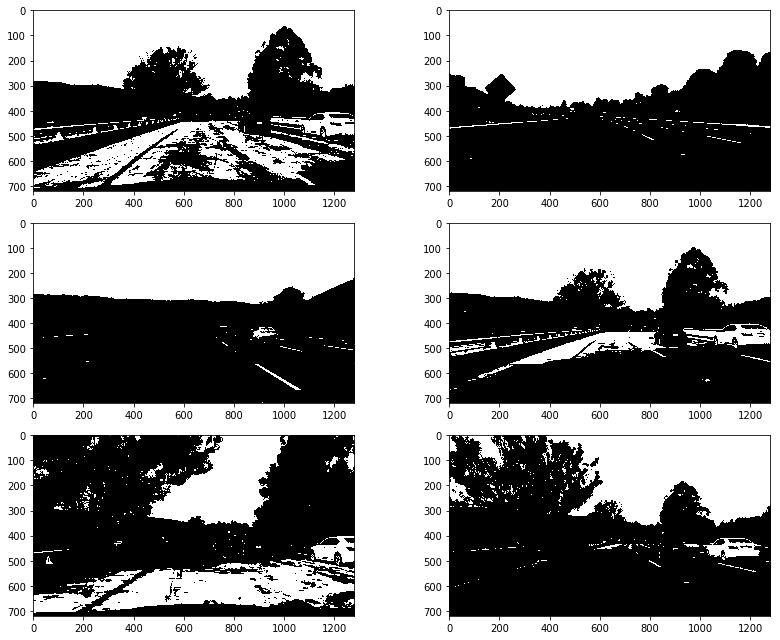

In [13]:
# RGB color space B thresholding
color_B_binaries = []
for image in test_images:
    B = RGB(image, space='B', thresh=(150,250))
    color_B_binaries.append(B)

multiplot(color_B_binaries, cmap='gray')

## g. RGB color space G thresholding - fail to obtain a good threshold

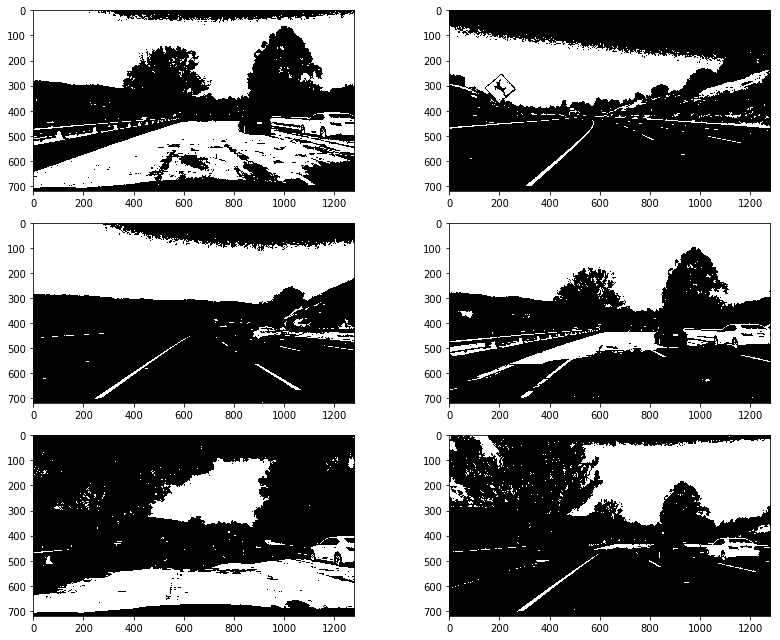

In [14]:
# RGB color space G thresholding
color_G_binaries = []
for image in test_images:
    G = RGB(image, space='G', thresh=(150,255))
    color_G_binaries.append(G)

multiplot(color_G_binaries, cmap='gray')

## h. HLS color space H thresholding - (20, 35)

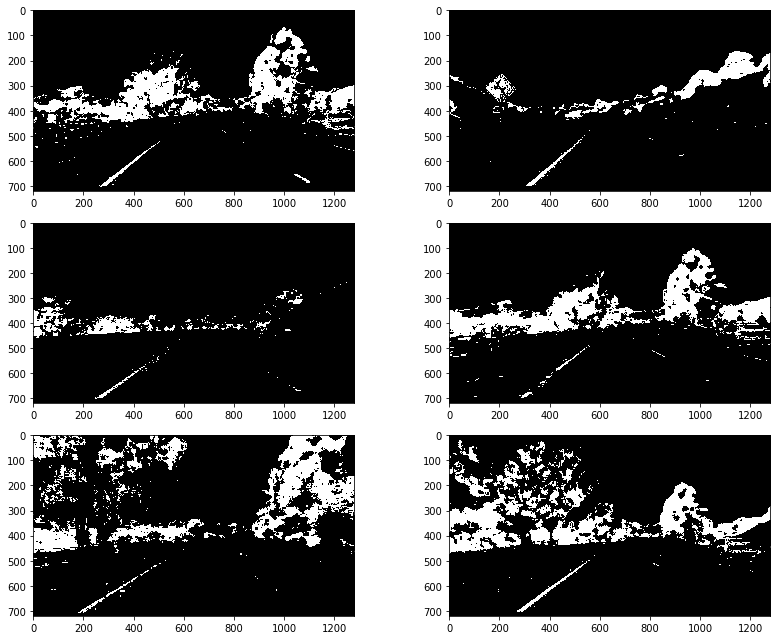

In [15]:
# HLS color space H thresholding
color_H_binaries = []
for image in test_images:
    H = hls(image, space='H', thresh=(20,35))
    color_H_binaries.append(H)

multiplot(color_H_binaries, cmap='gray')

## i. HLS color space L thresholding - (150, 200)

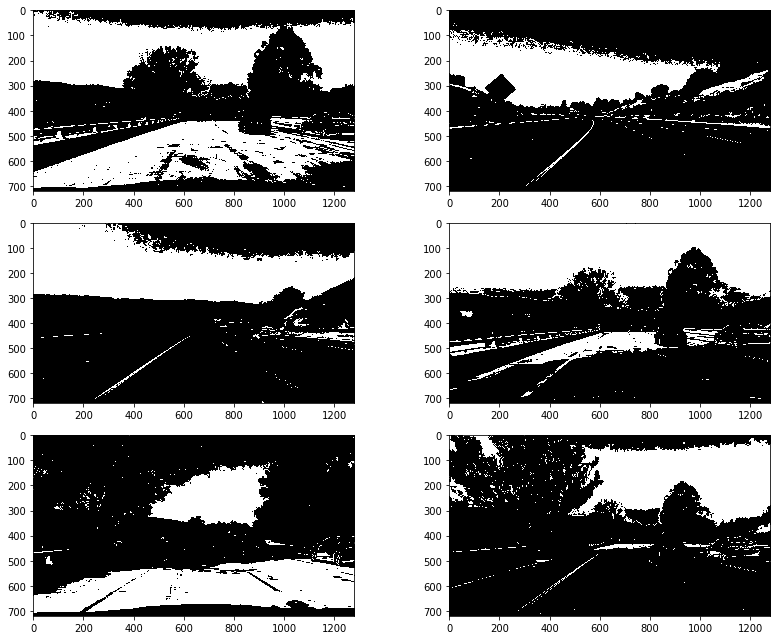

In [16]:
# HLS color space L thresholding
color_L_binaries = []
for image in test_images:
    L = hls(image, space='L', thresh=(150,200))
    color_L_binaries.append(L)

multiplot(color_L_binaries, cmap='gray')

## e. HLS color space S thresholding - (200, 255)

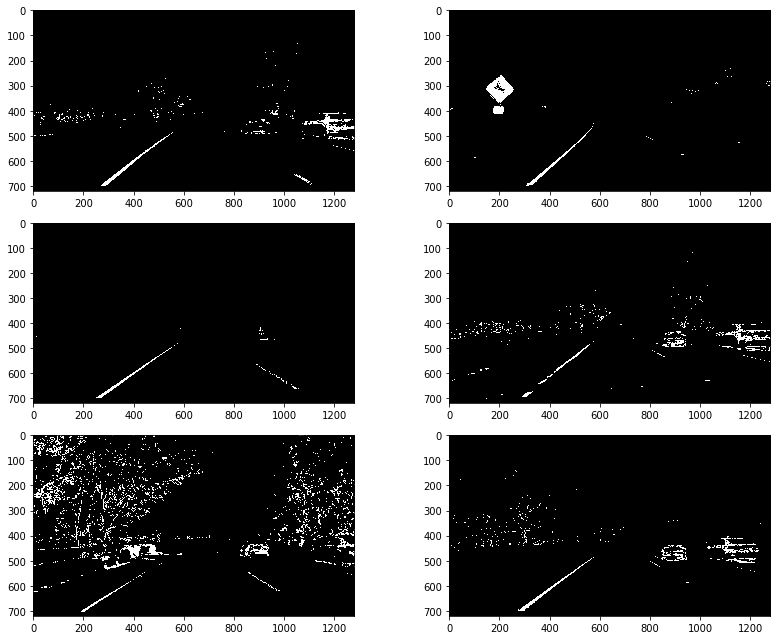

In [17]:
# HLS color space L thresholding
color_S_binaries = []
for image in test_images:
    S = hls(image, space='S', thresh=(200,255))
    color_S_binaries.append(S)

multiplot(color_S_binaries, cmap='gray')

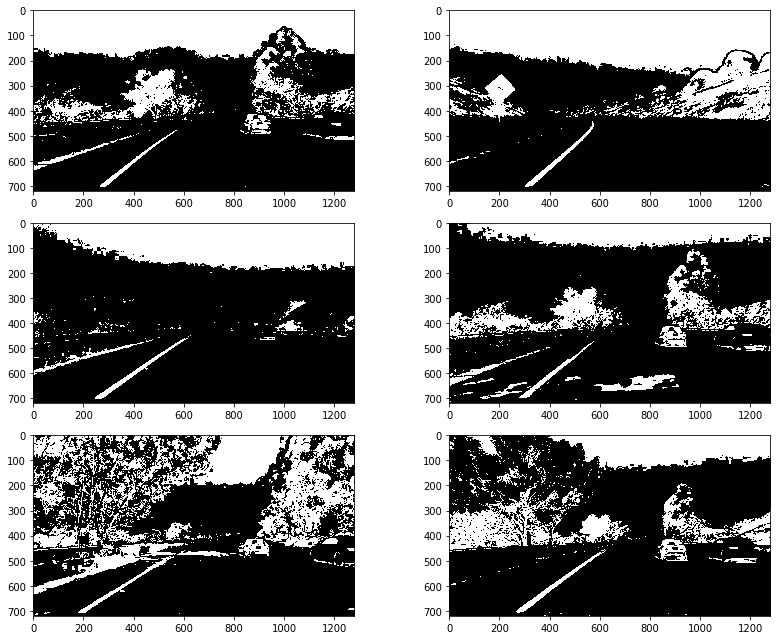

In [18]:
# HLS color space V thresholding
color_V_binaries = []
for image in test_images:
    V = hsv(image, space='V', thresh=(100,255))
    color_V_binaries.append(V)

multiplot(color_V_binaries, cmap='gray')

## Combine gradient and color space thresholds

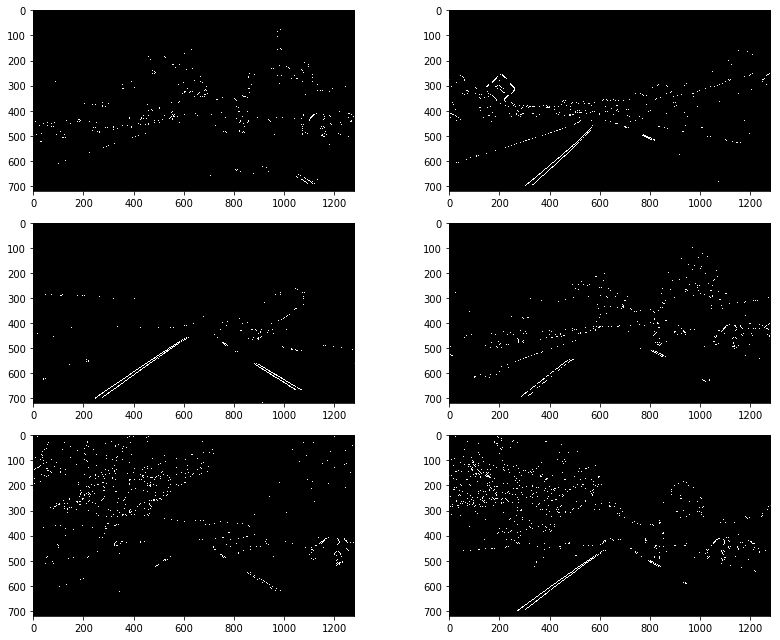

In [19]:
grad_combined_binaries = []
for i in range(len(dir_binaries)):
    grad_combined = np.zeros_like(dir_binaries[i])
    grad_combined[((gradx_binaries[i] == 1) & (grady_binaries[i] == 1)) | ((gradmag_binaries[i] == 1) & (dir_binaries[i] == 1))] = 1
    #grad_combined[(gradmag_binaries[i] == 1) & (dir_binaries[i] == 1)] = 1    
    grad_combined_binaries.append(grad_combined)

multiplot(grad_combined_binaries, cmap='gray')

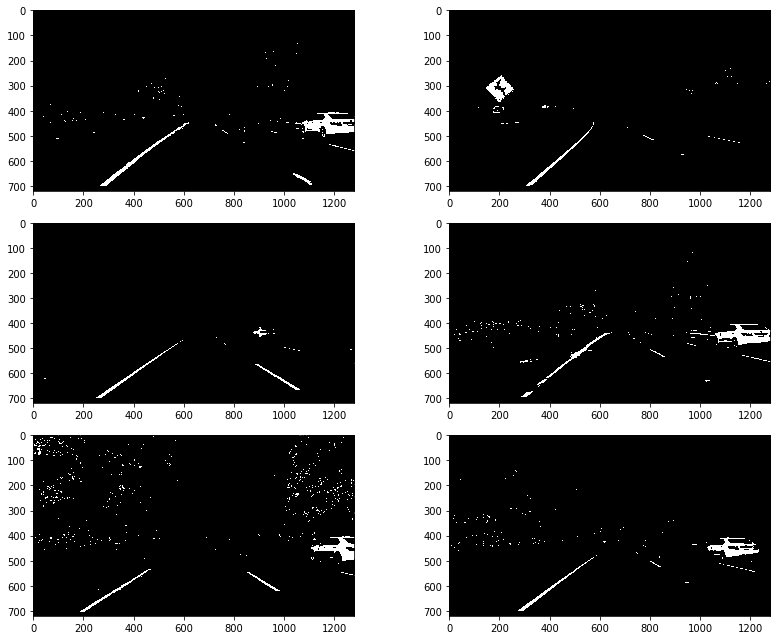

In [20]:
color_combined_binaries = []
for i in range(len(color_R_binaries)):
    color_combined = np.zeros_like(color_R_binaries[i])
    color_combined[(color_R_binaries[i] == 1) | ((color_H_binaries[i] == 1) & (color_S_binaries[i] == 1))] = 1
    color_combined_binaries.append(color_combined)

multiplot(color_combined_binaries, cmap='gray')

## Stack the gradient and color space lane lines

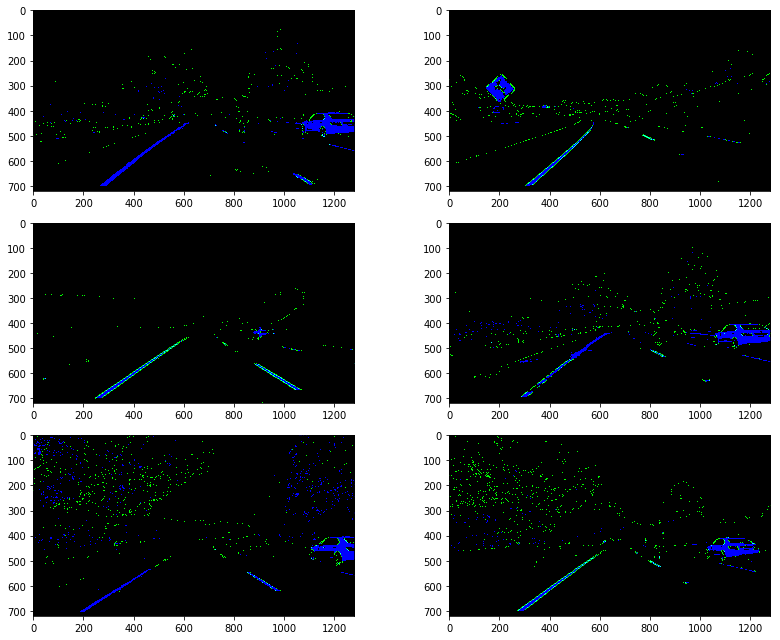

In [21]:
stacks = []
for i in range(len(grad_combined_binaries)):
    stack = np.dstack(( np.zeros_like(grad_combined_binaries[i]), grad_combined_binaries[i], color_combined_binaries[i]))
    stacks.append(stack)
    
multiplot(stacks)

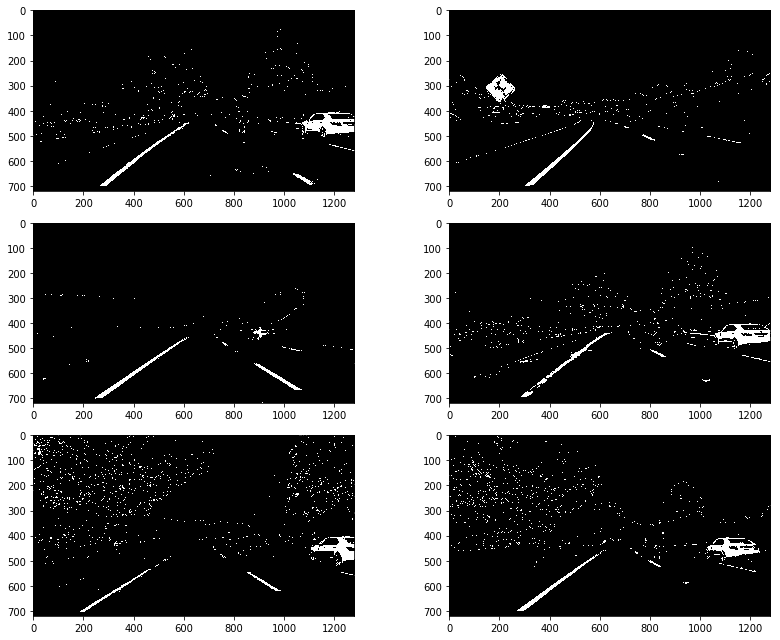

In [22]:
combined_binaries = []
for i in range(len(grad_combined_binaries)):
    combined_binary = np.zeros_like(grad_combined_binaries[i])
    combined_binary[(grad_combined_binaries[i] == 1) | (color_combined_binaries[i] == 1)] = 1
    combined_binaries.append(combined_binary)
    
multiplot(combined_binaries, cmap='gray')

In [23]:
nonzero = combined_binaries[0].nonzero()
x = nonzero[0]
y = nonzero[1]
combined_binaries[0][x,y]

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

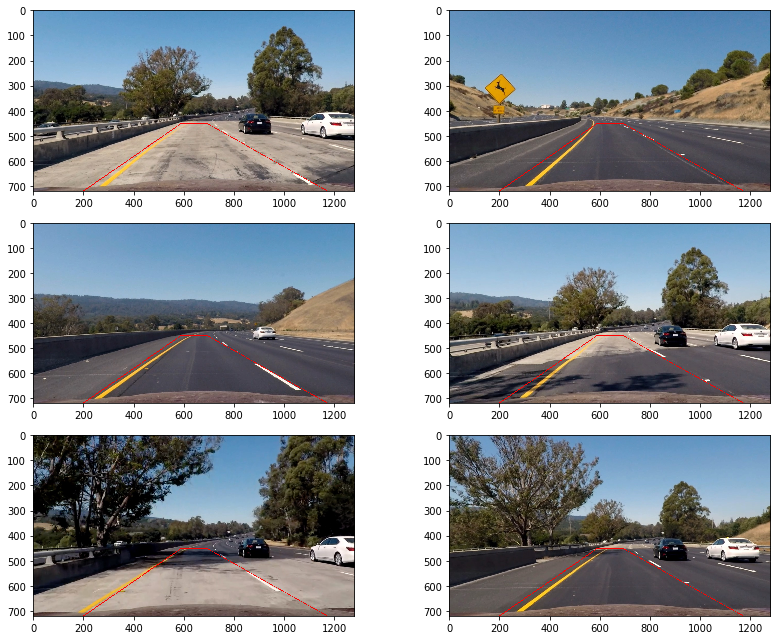

In [24]:
# define region of interest
test_images_wlines = copy.deepcopy(test_images)
vertices = [(200, 720), (590, 450), (690,450), (1170, 720)]
color = [255,0,0]
thickness = 2

for image in test_images_wlines:
    cv2.line(image, vertices[0], vertices[1], color, thickness)
    cv2.line(image, vertices[1], vertices[2], color, thickness)
    cv2.line(image, vertices[2], vertices[3], color, thickness)
    
multiplot(test_images_wlines)

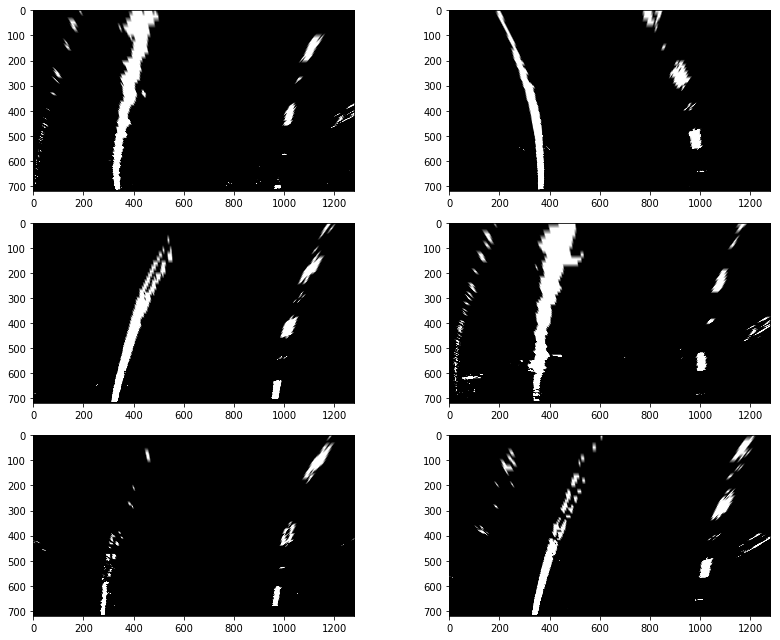

In [25]:
# Perspective transform
offset = 300
src = np.float32(vertices)
dst = np.float32([(offset, IMAGE_SIZE[1]), (offset, 0), (IMAGE_SIZE[0]-offset, 0), (IMAGE_SIZE[0]-offset, IMAGE_SIZE[1])])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped_images = []
for image in combined_binaries:
    warped = cv2.warpPerspective(image, M, IMAGE_SIZE, flags=cv2.INTER_LINEAR)
    warped_images.append(warped)
    
multiplot(warped_images, cmap='gray')

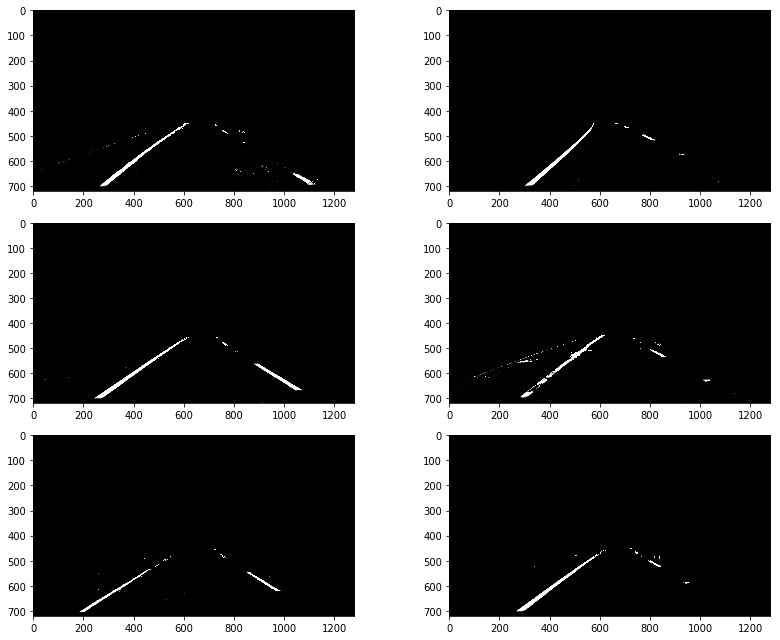

In [26]:
unwarped_images = []
for image in warped_images:
    unwarped = cv2.warpPerspective(image, Minv, IMAGE_SIZE, flags=cv2.INTER_LINEAR)
    unwarped_images.append(unwarped)
    
multiplot(unwarped_images, cmap='gray')

[ 0.125       0.25        0.40625    ...,  0.34375     0.34375     0.26855469]


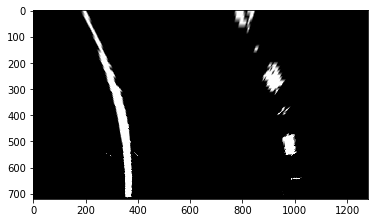

In [27]:
plt.imshow(warped_images[1], cmap='gray')
x = warped_images[5].nonzero()[0]
y = warped_images[5].nonzero()[1]
print (warped_images[5][x,y])

In [28]:
binary_warped= warped_images[0]
x = binary_warped.nonzero()[0]
y = binary_warped.nonzero()[1]
binary_warped[x,y]

array([ 0.0625    ,  0.21875   ,  0.34375   , ...,  0.15039062,
        0.40625   ,  0.17773438])

## Finding the lines

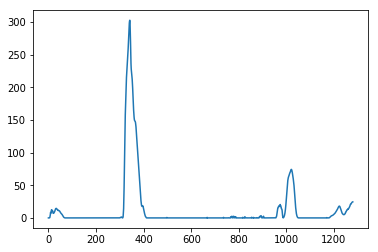

In [29]:
binary_warped = warped_images[0]
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [30]:
# Create an output image to draw and visualize
out_img =np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)

# find the peak of the left and right halves of the histogram
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

nwindows = 9
window_height = np.int(binary_warped.shape[0]/nwindows)

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

leftx_current = leftx_base
rightx_current = rightx_base

margin = 100
minpix = 50

left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 5)
    cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 5)
    
    
    good_left_inds = ((nonzeroy >= win_y_low)&(nonzeroy < win_y_high)&(nonzerox >= win_xleft_low)&(nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low)&(nonzeroy < win_y_high)&(nonzerox >= win_xright_low)&(nonzerox < win_xright_high)).nonzero()[0]
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    
    if len(good_right_inds) > minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


(720, 0)

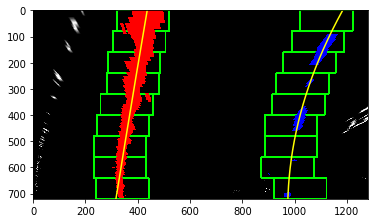

In [31]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0,1280)
plt.ylim(720,0)

In [32]:
# after we get the polinomial, use it for other images
binary_warped_2 = warped_images[4]
nonzero = binary_warped_2.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



(720, 0)

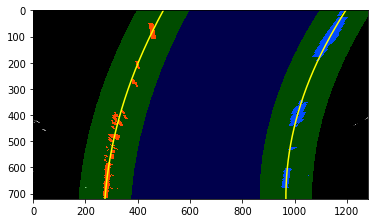

In [33]:
out_img = np.uint8(np.dstack((binary_warped_2, binary_warped_2, binary_warped_2))*255)
window_img = np.zeros_like(out_img)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

middle_line_pts = np.hstack((left_line_window2, right_line_window1))

cv2.fillPoly(window_img, np.int_([middle_line_pts]), (0,0,255))

cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [34]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = np.max(ploty)
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')



500.509470115 m 365.17124082 m


# 3. Build the pipeline

In [35]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 

def binarize(image):
    # apply best thresholds discovered in the Data Exploration phase
    binary_dir = direction(image, kernel_size=9, thresh=(0.5, 0.7))
    gradx = sobel(image, kernel_size=5, thresh=(50,255), method='x')
    grady = sobel(image, kernel_size=5, thresh=(50,255), method='y')
    gradmag = sobel(image, kernel_size=5, thresh=(50,255), method='mag')
    R = RGB(image, space='R', thresh=(220,255))
    H = hls(image, space='H', thresh=(20,35))
    S = hls(image, space='S', thresh=(200,255))
    
    # combined gradient and color space thresholding using logical operations
    grad_combined = np.zeros_like(gradx)
    grad_combined[((gradx == 1) & (grady == 1)) | ((gradmag == 1) & (binary_dir == 1))] = 1
    
    color_combined = np.zeros_like(R)
    color_combined[(R == 1) | ((H == 1) & (S == 1))] = 1
    
    combined_binary = np.zeros_like(color_combined)
    combined_binary[(grad_combined == 1) | (color_combined == 1)] = 1
    
    return combined_binary

def warp(image, src, dst, image_size):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    return warped
    
def unwarp(image, src, dst, image_size):
    Minv = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(image, Minv, image_size, flags=cv2.INTER_LINEAR)
    return unwarped

# fit function for the first frame of the video to find the line fit coeffs and the fited x and y values
def fit(binary_warped, nwindows = 9, margin = 100, minpix = 50):
    # build the histogram of the input image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # calculate the individual height of a window
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # find all nonzero points
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # initialize the first two points using the peak points from the histogram
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # define the dimension of the sliding window
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # find the pixels that fall within the window
        good_left_inds = ((nonzeroy >= win_y_low)&(nonzeroy < win_y_high)&(nonzerox >= win_xleft_low)&(nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low)&(nonzeroy < win_y_high)&(nonzerox >= win_xright_low)&(nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # update the position of the window for the next iteration
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # get the x, y position of all the points that are within the window
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # fit two second degree polinomial to the points detected
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit

# after running the fit function on the first frame of the video to get the original fit polynomial, use this function
# on the following frames to speed up the process
def find(binary_warped, left_fit, right_fit, margin=100):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

def curvature(ploty, left_fitx, right_fitx, ym_per_pix=30/720, xm_per_pix=3.7/700):
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

def draw_region(image, left_fitx, right_fitx, ploty, margin = 10):
    # Create an image to contain the lane region
    window_img = np.zeros_like(image)
    
    # find the lane line and lane region using the two fitted lines
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    middle_line_pts = np.hstack((left_line_window2, right_line_window1))
    
    cv2.fillPoly(window_img, np.int_([middle_line_pts]), (0,0,255))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    return window_img

def stack_region(image, window_img):
    result = cv2.addWeighted(image, 1, window_img, 0.3, 0)
    return result




In [36]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 


def find_lines(image):
    
    IMAGE_SIZE = (image.shape[1], image.shape[0])
    # load the camera calibration matrixes calculated previously
    cam_cal = pickle.load( open( "output_images/calibration_wide/mtx_dist.p", "rb" ) )
    mtx = cam_cal['mtx']
    dist = cam_cal['dist']
    
    # undistort image
    image = undist(image, mtx, dist)
    
    # binarize image
    binary = binarize(image)
    
    # warp image
    offset = 300
    src = np.float32([(200, 720), (590, 450), (690,450), (1170, 720)])
    dst = np.float32([(offset, IMAGE_SIZE[1]), (offset, 0), (IMAGE_SIZE[0]-offset, 0), (IMAGE_SIZE[0]-offset, IMAGE_SIZE[1])])
    binary_warped = warp(binary, src, dst, IMAGE_SIZE)
    
    # get the coeffs of the fitted lines
    left_fit, right_fit = fit(binary_warped)
    
    # calculate the line points using the fit coeffs
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # create an image for the lane region
    window_img = draw_region(image, left_fitx, right_fitx, ploty)
    
    # unwarp the lane region
    window_img = unwarp(window_img, src, dst, IMAGE_SIZE)
    
    #calculate the car position and curvature
    ym_per_pix=30/720
    xm_per_pix=3.7/700
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'
    
    left_curv, right_curv = curvature(ploty, left_fitx, right_fitx, ym_per_pix, xm_per_pix)
    
    
    # stack the lane region and the original image
    out_img = stack_region(image, window_img)
    
    cv2.putText(out_img, 'Left Radius of Curvature = '+str(round(left_curv,3))+'m', (50, 50), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    cv2.putText(out_img, 'Right Radius of Curvature = '+str(round(right_curv,3))+'m', (50, 100), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    cv2.putText(out_img, 'Vehicle is '+str(round(center_diff,3))+'m '+side_pos+' of center', (50, 150), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

    return out_img
    
    
    
    

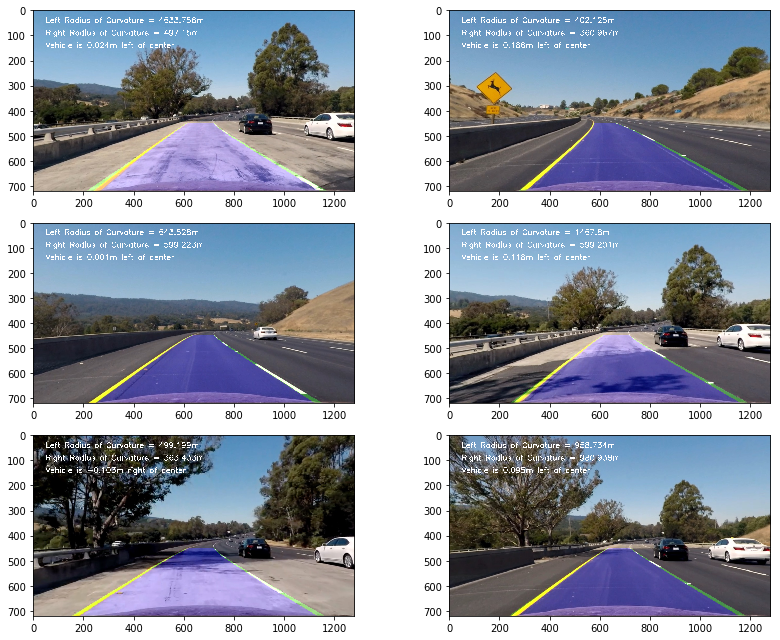

In [37]:
output_images = []
for image in test_images:
    out_img = find_lines(image)
    output_images.append(out_img)

multiplot(output_images)

In [38]:
from moviepy.editor import VideoFileClip
output_video = 'output1_tracked.mp4'
input_video = 'project_video.mp4'

clip1 = VideoFileClip(input_video)
video_clip = clip1.fl_image(find_lines)
video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output1_tracked.mp4
[MoviePy] Writing video output1_tracked.mp4


100%|█████████▉| 1260/1261 [06:32<00:00,  3.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output1_tracked.mp4 



In [39]:
#camera center
#https://youtu.be/vWY8YUayf9Q?list=PLAwxTw4SYaPkz3HerxrHlu1Seq8ZA7-5P&t=3780

#map fit line to lane line
#https://youtu.be/vWY8YUayf9Q?list=PLAwxTw4SYaPkz3HerxrHlu1Seq8ZA7-5P&t=3747

#save text on images
#https://youtu.be/vWY8YUayf9Q?list=PLAwxTw4SYaPkz3HerxrHlu1Seq8ZA7-5P&t=3989

#output video
#https://youtu.be/vWY8YUayf9Q?list=PLAwxTw4SYaPkz3HerxrHlu1Seq8ZA7-5P&t=4320